In [60]:
import os
import pathlib
from glob import glob
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import librosa
from sklearn.model_selection import train_test_split

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## TensorFlow.data API Pipeline

In [56]:
# listing files to later read them and their label
list_ds = tf.data.Dataset.list_files('../data/*/*.wav')
# checking the type of list_ds variable
list_ds

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [57]:
# length of the dataset
len(list_ds)

1440

In [58]:
# inspect the type of each element component
print(list_ds.element_spec)

# Use value_type to see the type of value represented by the element spec
print(list_ds.element_spec.value_type)

TensorSpec(shape=(), dtype=tf.string, name=None)
<class 'tensorflow.python.framework.ops.Tensor'>


In [40]:
# creating a function that will receive the filename in the list_ds
# and return the spectrogram of the file and its label
def load_audio(filename):
    #getting the label from the filename
    parts = tf.strings.split(filename, sep='-')
    label = int(parts[-5])-1
    # loading the file using librosa
    filename = filename.numpy().decode('utf-8')
    audio, sr = librosa.load(filename)
    # setting a threshold of 30 below reference to be considered as silence
    audio, _ = librosa.effects.trim(audio, top_db=30)
    # setting the same length
    target_size = 88200
    if len(audio) > target_size:
        audio = audio[:target_size]
    elif len(audio) < target_size:
        audio = librosa.util.pad_center(audio, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
    # getting the melspectrogram of the audio
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels = 128, )
    # converting the amplitude to db - approximates to how humans perceive sound
    spectrogram = librosa.amplitude_to_db(S, ref = np.max)
    #expanding dimension to match the shape expected in the convolutional NN    
    spectrogram = np.expand_dims(spectrogram, axis=2)
    # convert the spectrogram to a TensorFlow tensor to use tensorflow pipeline
    spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32) 
    return spectrogram, label

In [41]:
# applying load_audio in an individual file
# spec shape will be used in modelling
file_path = next(iter(list_ds))
spec, label = load_audio(file_path)
print(spec.shape)
print(label)

In [42]:
# applying load_audio to the whole list_ds dataset
# this map method using python functions was extracted from tensorflow.data API tutorials
audios_ds = list_ds.map(lambda filename:\
                tf.py_function(func=load_audio, inp=[filename], Tout=[tf.float32, tf.int32]))
audios_ds = audios_ds.map(lambda spectrogram, label: (tf.reshape(spectrogram, [128,173, 1]), tf.reshape(label,[])))
# now audios_ds contains the spectrograms and their respective labels
audios_ds.element_spec

(TensorSpec(shape=(128, 173, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [44]:
# getting the size of the dataset to further split some percentage of it into training and testing set
size_dataset = len(list(audios_ds))
size_dataset

1440

In [45]:
# shuffle the dataset that is currently ordered by class
audios_ds = audios_ds.shuffle(buffer_size=1000)

In [54]:
# taking 80% of the dataset to training set and the remaining 20% to the testing set
train = audios_ds.take(int(0.8*size_dataset)).cache().batch(32).prefetch(8)
test = audios_ds.skip(int(0.8*size_dataset)).take(int(0.2*size_dataset)).cache().batch(32).prefetch(8)

In [47]:
input_shape = spec.shape
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 5, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation = 'softmax'),
])

model.summary()

Input shape: (128, 173, 1)


2023-08-01 16:18:29.729968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 637 of 1000
2023-08-01 16:18:36.026124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 128, 173, 1)       3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 169, 64)      1664      
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 167, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 61, 83, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 61, 83, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 648064)           

In [48]:
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='rmsprop',
    metrics=['acc']
)

In [49]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/model_tf.h5')]

history = model.fit(
    train,
    validation_data=test,
    epochs=10,
    callbacks = callbacks
)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 6.2315 - acc: 0.2188

2023-08-01 16:19:31.364459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 597 of 1000
2023-08-01 16:19:37.742994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


36/36 [==============================] - 63s 2s/step - loss: 6.2315 - acc: 0.2188 - val_loss: 1.5902 - val_acc: 0.5972
Epoch 2/10
36/36 [==============================] - 39s 1s/step - loss: 1.5165 - acc: 0.4575 - val_loss: 1.0573 - val_acc: 0.7882
Epoch 3/10
36/36 [==============================] - 39s 1s/step - loss: 0.9738 - acc: 0.6649 - val_loss: 0.6858 - val_acc: 0.7743
Epoch 4/10
36/36 [==============================] - 39s 1s/step - loss: 0.5057 - acc: 0.8368 - val_loss: 0.3951 - val_acc: 0.8819
Epoch 5/10
36/36 [==============================] - 38s 1s/step - loss: 0.2409 - acc: 0.9184 - val_loss: 0.3674 - val_acc: 0.8993
Epoch 6/10
36/36 [==============================] - 38s 1s/step - loss: 0.1653 - acc: 0.9470 - val_loss: 0.4090 - val_acc: 0.8993
Epoch 7/10
36/36 [==============================] - 38s 1s/step - loss: 0.1126 - acc: 0.9514 - val_loss: 0.5912 - val_acc: 0.8785
Epoch 8/10
36/36 [==============================] - 38s 1s/step - loss: 0.0682 - acc: 0.9766 - val_lo

The validation accuracy 89.9% is a huge improvement from the baseline of 13.3%. The model is looking great. <br>
To be conversative of the performance of the model, other format of modelling will be tested to check this accuracy.

# Modelling with numpy format as inputs

In [61]:
# reading the metadata csv file to apply load_audio to the pandas series with the filepaths and labels
files_details = pd.read_csv('../csvs/files_details.csv')

In [89]:
# creating the function to apply 'load_audio' to the pandas series with the filepaths and labels
def load_audio(filename, label):
    # extracting the numpy array and the sampling rate of the signal
    audio, sr = librosa.load(filename)
    # setting a threshold of 30 below reference to be considered as silence
    audio, _ = librosa.effects.trim(audio, top_db=30)
    # setting the same length for every audio
    target_size = 88200
    if len(audio) > target_size:
        audio = audio[:target_size]
    elif len(audio) < target_size:
        audio = librosa.util.pad_center(audio, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050  
    # creating the melspectogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels = 128, )
    # setting db instead of amplitude - approximates of how humans perceive sound
    spectrogram = librosa.amplitude_to_db(S, ref = np.max)
    # expanding the dimension so that it matches the format expected in the convolutional NN
    spectrogram = np.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

In [97]:
# using load_audio to generate the X (spectrograms) and y (labels) to input to the model
X, y = [], []
for file_path, label in zip(files_details['file'], files_details['label']):
    spectrogram, label = load_audio(file_path, label)
    X.append(spectrogram)
    y.append(label)

# transforming to arrays and reshaping y to match the format expected in the convolutional NN 
X = np.array(X)
y = np.array(y, dtype=np.int32)
y = y.reshape(-1, 1)

In [100]:
# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [34]:
X_test[0].shape

(128, 173, 1)

In [39]:
# instantiating tf.keras.layers.Normalization layer
norm_layer = layers.Normalization()
# adapting the layer to the training set to add to the model
norm_layer.adapt(data=X_train)

model_2 = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    norm_layer,
    layers.Conv2D(64, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation = 'softmax'),
])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 128, 173, 1)       3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 169, 64)      1664      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 84, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 82, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 41, 128)       0         
 g2D)                                                            
                                                      

In [40]:
model_2.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='rmsprop',
    metrics=['acc']
)

In [41]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/model_old_format_2.h5')]

history_2 = model_2.fit( x = X_train,
    y = y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=30,
    callbacks = callbacks
)

Epoch 1/30
36/36 [==============================] - 11s 301ms/step - loss: 2.8996 - acc: 0.2283 - val_loss: 1.7289 - val_acc: 0.3924
Epoch 2/30
36/36 [==============================] - 11s 297ms/step - loss: 1.6236 - acc: 0.4036 - val_loss: 1.4875 - val_acc: 0.4757
Epoch 3/30
36/36 [==============================] - 11s 301ms/step - loss: 1.2943 - acc: 0.5512 - val_loss: 1.3517 - val_acc: 0.5174
Epoch 4/30
36/36 [==============================] - 11s 305ms/step - loss: 0.9425 - acc: 0.6623 - val_loss: 1.3090 - val_acc: 0.5625
Epoch 5/30
36/36 [==============================] - 11s 300ms/step - loss: 0.6058 - acc: 0.7830 - val_loss: 1.2014 - val_acc: 0.5799
Epoch 6/30
36/36 [==============================] - 11s 300ms/step - loss: 0.3911 - acc: 0.8628 - val_loss: 1.1382 - val_acc: 0.5972
Epoch 7/30
36/36 [==============================] - 11s 299ms/step - loss: 0.2376 - acc: 0.9167 - val_loss: 1.3100 - val_acc: 0.6285
Epoch 8/30
36/36 [==============================] - 11s 298ms/step - 

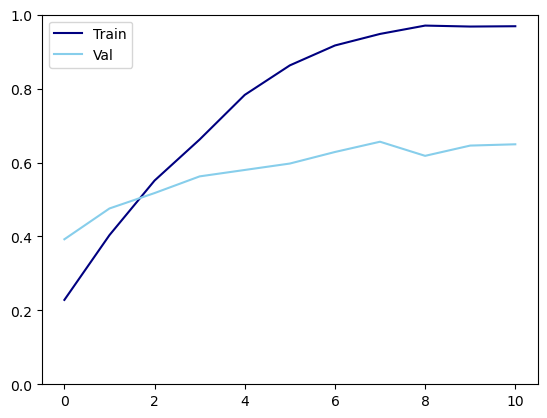

In [43]:
# Plot our loss chart - what do we see?
plt.plot(history_2.history['acc'], c='navy', label='Train')
plt.plot(history_2.history['val_acc'], c='skyblue', label='Val')
plt.ylim(0, 1)
plt.legend();

The validation accuracy using the numpy format is much lower. It is possible that this difference is due to potential data leakage in the other format. Other methods to split the data will be testes in the other format. The model considered will be this model that has numpy array as inputs and has an accuracy of 65%. <br>
The validation accuracy of 65% is much better than the baseline 13.3%. This shows there are potential uses and improvement for the model. <br>
Some suggestions may be to incorporate more datasets, files, incorporating more emotions, different actors and different phrases so that it is more generalizable. <br>
Since the model is overfit, further regularizations through L1, L2 regularizers and testing different dropouts could possibly lead to improved overfitting.

References:
- TensorFlow Tutorials
- Nicholas Renotte's Audio Classification tutorial on youtube: https://www.youtube.com/watch?v=ZLIPkmmDJAc